# Classification using a pretrained VGG on ImageNet


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
import time
import tensorflow as tf
import librosa, librosa.display


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.layers import Reshape, MaxPooling2D, Softmax
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import SGD

from IPython import display
import random
from google.colab import drive


drive.mount('/content/drive/')
%cd 'drive/MyDrive/DLOI_Project'

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1K5OFKaoitJ_c6tsV6UYFW_Ts0E8dqdld/DLOI_Project


## Dataset

!! Based and Trained on a subset of VGGVox1 that is not available anymore !!

In [ ]:
# Download dataset
!gdown 1-2_584NonvhhTgTEO0VBZrfooKxQujnT
from scipy.sparse import load_npz
data = load_npz('/content/drive/MyDrive/DLOI_Project/audVisIdn.npz')

### Loading ground truth, pictures of speaker and the audio recordings

In [ ]:
path_person_test='dataset/person_test.npy'
path_person_train='dataset/person_train.npy'
path_person_val='dataset/person_val.npy'


path_audioTrs_test='dataset/audioTrs_test.npy'
path_audioTrs_train='dataset/audioTrs_train.npy'
path_audioTrs_val='dataset/audioTrs_val.npy'

path_imgFrames_test='dataset/imgFrames_test.npy'
path_imgFrames_train='dataset/imgFrames_train.npy'
path_imgFrames_val='dataset/imgFrames_val.npy'


person_test = np.load(path_person_test, mmap_mode='r')
person_train = np.load(path_person_train, mmap_mode='r')
person_val = np.load(path_person_val, mmap_mode='r')

audioTrs_test = np.load(path_audioTrs_test, mmap_mode='r')
audioTrs_train = np.load(path_audioTrs_train, mmap_mode='r')
audioTrs_val = np.load(path_audioTrs_val, mmap_mode='r')

imgFrames_test = np.load(path_imgFrames_test, mmap_mode='r')
imgFrames_train = np.load(path_imgFrames_train, mmap_mode='r')
imgFrames_val = np.load(path_imgFrames_val, mmap_mode='r')


print('Person :')
print(np.shape(person_test)) 
print(np.shape(person_train)) 
print(np.shape(person_val)) 

print('Audio :')
print(np.shape(audioTrs_test)) 
print(np.shape(audioTrs_train)) 
print(np.shape(audioTrs_val)) 

print('Frame :')
print(np.shape(imgFrames_test)) 
print(np.shape(imgFrames_train)) 
print(np.shape(imgFrames_val)) 

nb_img_train, input_size, input_size, nb_channel = np.shape(imgFrames_train)


download_audio_images = True

if download_audio_images:
  S_DB_val_path='audio/AudioImages_Val.npy'
  S_DB_path='audio/AudioImages_Train.npy'
  S_DB_test_path='audio/AudioImages_Test.npy'

  S_DB_val = abs(np.load(S_DB_val_path, mmap_mode='r'))
  S_DB_test = abs(np.load(S_DB_test_path, mmap_mode='r'))
  S_DB = abs(np.load(S_DB_path, mmap_mode='r'))

Person :
(950,)
(2850,)
(950,)
Audio :
(950, 56000)
(2850, 56000)
(950, 56000)
Frame :
(950, 224, 224, 3)
(2850, 224, 224, 3)
(950, 224, 224, 3)


### Change the GT to categorical labels and create one-hot encoding

In [ ]:
# Normalization
def NormalizeData(data):
    return 2*((data - np.min(data)) / (np.max(data) - np.min(data)))-1

def DenormalizeData(data):
    return (256*((data+1)/2)).astype(int)

GT = list(np.unique(person_train))
new_id = [i for i in range(49)]
id_dict = {}
for k in range(len(GT)):
  id_dict[GT[k]] = new_id[k]

nb_class=49

person_train_GT = []
for i in range(person_train.shape[0]):
  person_train_GT.append(id_dict[person_train[i]]) 
person_train_GT = np.stack(person_train_GT)
output_train_class_onehot = tf.keras.utils.to_categorical(person_train_GT, nb_class)  # create one-hot encoded class

person_val_GT = []
for i in range(person_val.shape[0]):
  person_val_GT.append(id_dict[person_val[i]]) 
person_val_GT = np.stack(person_val_GT)
output_val_class_onehot = tf.keras.utils.to_categorical(person_val_GT, nb_class)  # create one-hot encoded class

person_test_GT = []
for i in range(person_test.shape[0]):
  person_test_GT.append(id_dict[person_test[i]]) 
person_test_GT = np.stack(person_test_GT)
output_test_class_onehot = tf.keras.utils.to_categorical(person_test_GT, nb_class)  # create one-hot encoded class
   
print('Person GT:')
print(np.shape(person_test_GT)) 
print(np.shape(person_train_GT)) 
print(np.shape(person_val_GT)) 


Person GT:
(950,)
(2850,)
(950,)


## Processing of the audio file

In [ ]:
print('Audio :')
print(np.shape(audioTrs_test)) 
print(np.shape(audioTrs_train)) 
print(np.shape(audioTrs_val)) 


Audio :
(950, 56000)
(2850, 56000)
(950, 56000)


### Adds data augmentation by including a time-shift in the audio recodings

In [ ]:
def time_shift(aud, GT, shift_limit, nbr_augment):
  rolled = []
  rolled_GT = []
  for k in range(aud.shape[0]):
    rolled.append(aud[k])
    rolled_GT.append(GT[k])
    for i in range(nbr_augment):
      shift_rnd = random.random()
      if i == 0:
        shift_rnd = - shift_rnd
      rolled.append(np.roll(aud[k], shift=int(shift_rnd * shift_limit)))
      rolled_GT.append(np.roll(GT[k], shift=int(shift_rnd * shift_limit)))
    
  rolled = np.stack(rolled)
  rolled_GT = np.stack(rolled_GT)

  rolled = rolled

  return rolled, rolled_GT

In [ ]:
# Augment the audio files
train_aug,train_aug_GT = time_shift(audioTrs_train[:],person_train_GT[:] , 2000, 2)

In [ ]:
# create one-hot encoded class
output_train_class_onehot_aug = tf.keras.utils.to_categorical(train_aug_GT, nb_class)

Initial audio shape


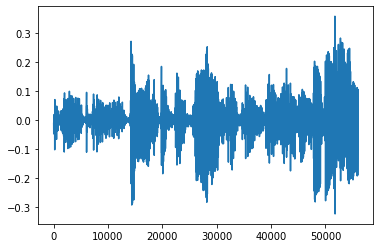

After augmentation


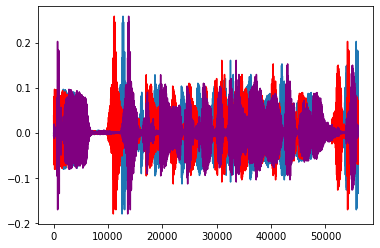

In [ ]:
print("Initial audio shape")
plt.figure()
plt.plot(audioTrs_train[3])
plt.show()

print("After augmentation")
plt.figure()
plt.plot(train_aug[3])
plt.plot(train_aug[4], 'r')
plt.plot(train_aug[5], 'purple')
plt.show()


### Transformation to spectrogram to process the audio files as images

In [ ]:
SPEC = True

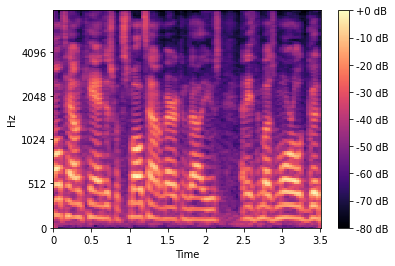

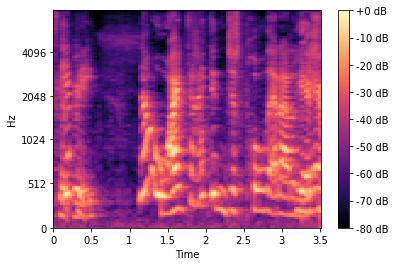

In [ ]:
if not download_audio_images and SPEC:
  sr = 16000

  #training 
  S_DB = []
  for i in range(train_aug.shape[0]):
    S = librosa.feature.melspectrogram(train_aug[i], sr=sr, n_fft=2048, hop_length=512)
    S_DB.append(np.stack([librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max)], axis=2))

  S_DB = np.stack(S_DB, axis = 0)
    
  librosa.display.specshow(S_DB[2,:,:,0], sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')

  # validation
  S_DB_val = []
  for i in range(audioTrs_val.shape[0]):
    S = librosa.feature.melspectrogram(audioTrs_val[i], sr=sr, n_fft=2048, hop_length=512)
    S_DB_val.append(np.stack([librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max)], axis=2))

  S_DB_val = np.stack(S_DB_val, axis = 0)

  plt.figure()
  librosa.display.specshow(S_DB_val[2,:,:,0], sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')

  S_DB_test = []
  for i in range(audioTrs_test.shape[0]):
    S = librosa.feature.melspectrogram(audioTrs_test[i], sr=sr, n_fft=2048, hop_length=512)
    S_DB_test.append(np.stack([librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max)], axis=2))

  S_DB_test = np.stack(S_DB_test, axis = 0)


Test with MFCC, not investigate as it does not seems concluant

In [ ]:
if not download_audio_images and not SPEC:
  sr = 16000

  #training 
  S_DB = []
  for i in range(train_aug.shape[0]):
    S = librosa.feature.mfcc(train_aug[i], sr=sr)
    S_DB.append(np.stack([S, S, S], axis=2))

  S_DB = np.stack(S_DB, axis = 0)
    
  librosa.display.specshow(S_DB[2,:,:,0], sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')

  # validation
  S_DB_val = []
  for i in range(audioTrs_val.shape[0]):
    S = librosa.feature.mfcc(audioTrs_val[i], sr=sr)
    S_DB_val.append(np.stack([S, S, S], axis=2))

  S_DB_val = np.stack(S_DB_val, axis = 0)

  plt.figure()
  librosa.display.specshow(S_DB_val[2,:,:,0], sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')

  S_DB_test = []
  for i in range(audioTrs_test.shape[0]):
    S = librosa.feature.mfcc(audioTrs_test[i], sr=sr)
    S_DB_test.append(np.stack([S, S, S], axis=2))

  S_DB_test = np.stack(S_DB_test, axis = 0)


In [ ]:
if not SPEC and not download_audio_images:
  ones_train = np.ones(S_DB.shape)*(abs(np.min(S_DB)))
  ones_test = np.ones(S_DB_test.shape)*(abs(np.min(S_DB)))
  ones_val = np.ones(S_DB_val.shape)*(abs(np.min(S_DB)))
  S_DB = S_DB + ones_train
  S_DB_val = S_DB_val + ones_val
  S_DB_test = S_DB_test + ones_test

Save the images on drive

In [ ]:
to_save = not download_audio_images
if to_save and SPEC: 
  np.save('AudioImages_Train', S_DB)
  np.save('AudioImages_Val', S_DB_val)
  np.save('AudioImages_Test', S_DB_test)
elif to_save and not SPEC: 
  %cd audio
  np.save('AudioImages_Train_MFFC', S_DB)
  np.save('AudioImages_Val_MFFC', S_DB_val)
  np.save('AudioImages_Test_MFFC', S_DB_test)
  %cd ..


/content/drive/.shortcut-targets-by-id/1K5OFKaoitJ_c6tsV6UYFW_Ts0E8dqdld/DLOI_Project/audio
/content/drive/.shortcut-targets-by-id/1K5OFKaoitJ_c6tsV6UYFW_Ts0E8dqdld/DLOI_Project


# VGG pretrained on imagenet

In [ ]:
import os
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

### VGG16 model definition

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## VGG19 model definition

In [ ]:
def create_model_deeper(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG19(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.3)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

## Training parameters definition

In [ ]:
input_shape = (S_DB_val[0].shape[0],S_DB_val[0].shape[1],S_DB_val[0].shape[2])


opti = tf.keras.optimizers.Adam(learning_rate=0.0001)
n_classes=49
BATCH_SIZE = 64
n_epochs = 15
nbr_ft_layer = 2
batch_shuffle = True

## VGG16 Model construction

In [ ]:
vgg_model_ft = create_model(input_shape, n_classes,opti, fine_tune=nbr_ft_layer)


In [ ]:
vgg_model_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 110, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 110, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 110, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 55, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 55, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 55, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 27, 128)       0     

## VGG16 Training using the augmented audio melspectrogram

In [ ]:
output_train_class_onehot_aug = tf.keras.utils.to_categorical(train_aug_GT, nb_class)  # create one-hot encoded class


In [ ]:
vgg_history_MS = vgg_model_ft.fit(S_DB,
                                output_train_class_onehot_aug,
                                batch_size=BATCH_SIZE,
                                epochs=n_epochs,
                                shuffle = batch_shuffle,
                                validation_data=(S_DB_val,output_val_class_onehot)) 

Epoch 1/15
134/134 [==============================] - 16s 109ms/step - loss: 2.3647 - accuracy: 0.4256 - val_loss: 1.9767 - val_accuracy: 0.4632
Epoch 2/15
134/134 [==============================] - 14s 107ms/step - loss: 0.4323 - accuracy: 0.8752 - val_loss: 2.3321 - val_accuracy: 0.4989
Epoch 3/15
134/134 [==============================] - 14s 108ms/step - loss: 0.0678 - accuracy: 0.9854 - val_loss: 2.1306 - val_accuracy: 0.5526
Epoch 4/15
134/134 [==============================] - 15s 109ms/step - loss: 0.0191 - accuracy: 0.9972 - val_loss: 2.1515 - val_accuracy: 0.5653
Epoch 5/15
134/134 [==============================] - 15s 110ms/step - loss: 0.0070 - accuracy: 0.9996 - val_loss: 2.3204 - val_accuracy: 0.5547
Epoch 6/15
134/134 [==============================] - 15s 110ms/step - loss: 0.0034 - accuracy: 0.9999 - val_loss: 2.3048 - val_accuracy: 0.5674
Epoch 7/15
134/134 [==============================] - 15s 111ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.3623 - val_ac

In [ ]:
%cd trained_models
vgg_model_ft.save('MS_Model')
%cd ..
# to load back model: keras.models.load_model('MS_Model')

### Augmented audio file performances of VGG16

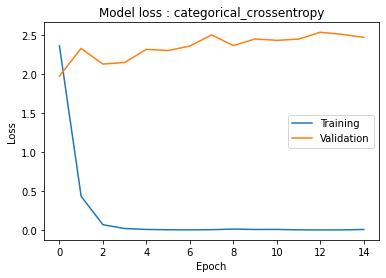

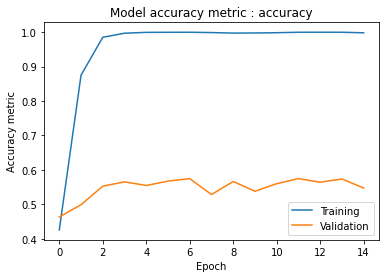

In [ ]:
# model loss
loss='categorical_crossentropy'
metrics=['accuracy']

plt.plot(vgg_history_MS.history['loss'])
plt.plot(vgg_history_MS.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(vgg_history_MS.history[metrics[0]]))
plt.plot(np.array(vgg_history_MS.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

In [ ]:
from keras.backend import argmax
acc = 0
for i in range(audioTrs_test.shape[0]):
  output_predict = argmax(vgg_model_ft.predict(tf.expand_dims(S_DB_test[i], axis=0))).numpy()[0]
  if output_predict == np.argmax(output_test_class_onehot[i]):
    acc += 1
acc /= audioTrs_test.shape[0]
print("Accuracy on test set: {:3f}%".format(acc*100))

Accuracy on test set: 54.210526%


## VGG19 Training using the augmented audio melspectrogram

In [ ]:
vgg_model_deeper = create_model_deeper(input_shape, n_classes,opti, fine_tune=3)


In [ ]:
vgg_model_deeper.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 110, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 110, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 110, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 55, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 55, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 55, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 27, 128)       0   

In [ ]:
vgg_history_deeper = vgg_model_deeper.fit(S_DB,
                                output_train_class_onehot_aug,
                                batch_size=BATCH_SIZE,
                                epochs=25,
                                shuffle = batch_shuffle,
                                validation_data=(S_DB_val,output_val_class_onehot)) 

Epoch 1/25
134/134 [==============================] - 21s 144ms/step - loss: 3.6965 - accuracy: 0.0788 - val_loss: 3.5297 - val_accuracy: 0.0926
Epoch 2/25
134/134 [==============================] - 19s 143ms/step - loss: 3.3734 - accuracy: 0.0958 - val_loss: 3.3319 - val_accuracy: 0.1074
Epoch 3/25
134/134 [==============================] - 19s 144ms/step - loss: 3.2164 - accuracy: 0.1185 - val_loss: 3.2440 - val_accuracy: 0.1189
Epoch 4/25
134/134 [==============================] - 19s 140ms/step - loss: 3.0761 - accuracy: 0.1374 - val_loss: 3.1873 - val_accuracy: 0.1242
Epoch 5/25
134/134 [==============================] - 19s 139ms/step - loss: 2.9723 - accuracy: 0.1498 - val_loss: 3.1422 - val_accuracy: 0.1284
Epoch 6/25
134/134 [==============================] - 19s 140ms/step - loss: 2.8694 - accuracy: 0.1553 - val_loss: 3.1557 - val_accuracy: 0.1221
Epoch 7/25
134/134 [==============================] - 19s 141ms/step - loss: 2.7721 - accuracy: 0.1695 - val_loss: 3.1271 - val_ac

### Augmented audio file performances of VGG19

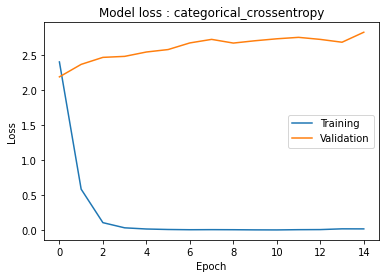

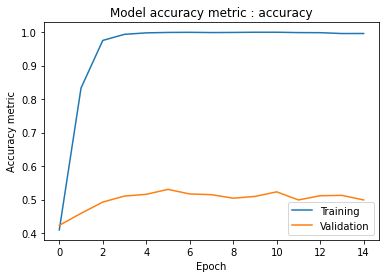

In [ ]:
# model loss
loss='categorical_crossentropy'
metrics=['accuracy']

plt.plot(vgg_history_deeper.history['loss'])
plt.plot(vgg_history_deeper.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(vgg_history_deeper.history[metrics[0]]))
plt.plot(np.array(vgg_history_deeper.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

In [ ]:
from keras.backend import argmax
acc = 0
for i in range(audioTrs_test.shape[0]):
  #S = librosa.feature.melspectrogram(audioTrs_test[i], sr=sr, n_fft=2048, hop_length=512)
  #S_DB_test = np.stack([librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max),librosa.power_to_db(S, ref=np.max)], axis=2)
  output_predict = argmax(vgg_model_deeper.predict(tf.expand_dims(S_DB_test[i], axis=0))).numpy()[0]
  if output_predict == np.argmax(output_test_class_onehot[i]):
    acc += 1
acc /= audioTrs_test.shape[0]
print("Accuracy on test set: {:3f}%".format(acc*100))

Accuracy on test set: 52.421053%


## VGG16 Training using the non-augmented audio melspectrogram

Only using the original data, i.e. the non time-shifted ones

In [ ]:
fuse_id = []
for i in range(S_DB.shape[0]):
  fuse_id.append(i%3 == 0)
S_DB_nn_aug = S_DB[fuse_id]

Model creation and training

In [ ]:
vgg_model_NA = create_model(input_shape, n_classes,opti, fine_tune=nbr_ft_layer)

In [ ]:
vgg_history_NA = vgg_model_NA.fit(S_DB_nn_aug,
                                output_train_class_onehot,
                                batch_size=BATCH_SIZE,
                                epochs=n_epochs,
                                shuffle = batch_shuffle,
                                validation_data=(S_DB_val,output_val_class_onehot)) 

Epoch 1/15
45/45 [==============================] - 7s 133ms/step - loss: 3.6835 - accuracy: 0.1842 - val_loss: 2.7519 - val_accuracy: 0.2789
Epoch 2/15
45/45 [==============================] - 6s 130ms/step - loss: 1.9996 - accuracy: 0.4498 - val_loss: 2.1811 - val_accuracy: 0.4158
Epoch 3/15
45/45 [==============================] - 6s 132ms/step - loss: 1.1516 - accuracy: 0.6733 - val_loss: 2.0507 - val_accuracy: 0.4484
Epoch 4/15
45/45 [==============================] - 6s 133ms/step - loss: 0.5973 - accuracy: 0.8295 - val_loss: 2.0396 - val_accuracy: 0.4653
Epoch 5/15
45/45 [==============================] - 6s 135ms/step - loss: 0.2406 - accuracy: 0.9312 - val_loss: 1.9762 - val_accuracy: 0.4989
Epoch 6/15
45/45 [==============================] - 6s 133ms/step - loss: 0.0905 - accuracy: 0.9839 - val_loss: 2.2248 - val_accuracy: 0.4926
Epoch 7/15
45/45 [==============================] - 6s 136ms/step - loss: 0.0397 - accuracy: 0.9940 - val_loss: 2.2698 - val_accuracy: 0.4916
Epoch 

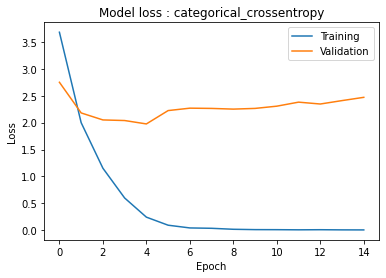

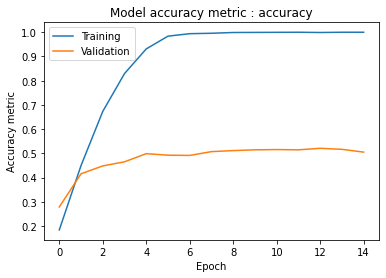

In [ ]:
# model loss
loss='categorical_crossentropy'
metrics=['accuracy']

plt.plot(vgg_history_NA.history['loss'])
plt.plot(vgg_history_NA.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(vgg_history_NA.history[metrics[0]]))
plt.plot(np.array(vgg_history_NA.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

In [ ]:
from keras.backend import argmax
acc = 0
for i in range(audioTrs_test.shape[0]):
  output_predict = argmax(vgg_model_NA.predict(tf.expand_dims(S_DB_test[i], axis=0))).numpy()[0]
  if output_predict == np.argmax(output_test_class_onehot[i]):
    acc += 1
acc /= audioTrs_test.shape[0]
print("Accuracy on test set: {:3f}%".format(acc*100))

Accuracy on test set: 52.526316%


# Transformers (ViT) using Audio files


In [ ]:
# ViT
!pip install -qq -U tensorflow-addons

import tensorflow_addons as tfa
import math

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

     |████████████████████████████████| 1.1 MB 11.7 MB/s 


Rescale the data to match RGB images

In [ ]:
# Scale spectrogram values to match cv image sizes
max_val = np.max([np.max(S_DB), np.max(S_DB_val), np.max(S_DB_test)])

S_DB = 255/max_val*S_DB
S_DB_val = 255/max_val*S_DB_val
S_DB_test = 255/max_val*S_DB_test

Retrieve only the non augmented data

In [ ]:
fuse_id = []
for i in range(S_DB.shape[0]):
  fuse_id.append(i%3 == 0)
S_DB_fuse = S_DB[fuse_id]


In [ ]:
## Data adaptation for transformers

# Downsampling
import cv2
def downsample_image(dataset, chosen_input_size):
  # INTER_LINEAR or INTER_AREA
  return [cv2.resize(image, (chosen_input_size, chosen_input_size), interpolation=cv2.INTER_AREA) for image in dataset]

down_sample=True  # True to downsample dataset
down_sampled=False
fuse = False

if down_sample and not down_sampled:
  if not fuse:
    chosen_input_size=S_DB[0].shape[1]

    imgFrames_train=np.array(downsample_image(S_DB, chosen_input_size))
    imgFrames_val=np.array(downsample_image(S_DB_val, chosen_input_size))
    INPUT_SHAPE = (chosen_input_size, chosen_input_size, nb_channel)

  else:
    chosen_input_size=32
    INPUT_SHAPE_IMG = (chosen_input_size, chosen_input_size, nb_channel)
    imgFrames_train_img=np.array(downsample_image(imgFrames_train, chosen_input_size))
    imgFrames_val_img=np.array(downsample_image(imgFrames_val, chosen_input_size))

    chosen_input_size=S_DB[0].shape[1]
    INPUT_SHAPE_AUDIO = (chosen_input_size, chosen_input_size, nb_channel)

    imgFrames_train_audio=np.array(downsample_image(S_DB_fuse, chosen_input_size))
    imgFrames_val_audio=np.array(downsample_image(S_DB_val, chosen_input_size))

  down_sampled=True
elif  not down_sample and not down_sampled:
  if not fuse:
    INPUT_SHAPE = (input_size, input_size, nb_channel)
  else:
    chosen_input_size=S_DB[0].shape[1]
    INPUT_SHAPE_AUDIO = (chosen_input_size, chosen_input_size, nb_channel)
    chosen_input_size=32
    INPUT_SHAPE_IMG = (chosen_input_size, chosen_input_size, nb_channel)
else :
  print("Already downsampled")

print('Person :')
print(np.shape(person_val_GT)) 
print(np.shape(train_aug_GT)) 

print('Frame :')
print(np.shape(imgFrames_val)) 
print(np.shape(imgFrames_train)) 

NUM_CLASSES = nb_class


# Normalization and shuffle
norm=1 # already performed in data-augmentation

if fuse:
  x_train_img=imgFrames_train_img/norm
  r=random.sample(range(len(x_train_img)), len(x_train_img)) # shuffle data
  x_train_img=x_train_img[r]
  y_train_fuse=person_train_GT[r]

  x_train_audio=imgFrames_train_audio/norm
  x_train_audio=x_train_audio[r]

  x_val_img=imgFrames_val_img/norm
  r=random.sample(range(len(x_val_img)), len(x_val_img))
  x_val_img=x_val_img[r]
  y_val_fuse=person_val_GT[r]

  x_val_audio=imgFrames_val_audio/norm
  x_val_audio=x_val_audio[r]


else:
  x_train=imgFrames_train/norm
  r=random.sample(range(len(x_train)), len(x_train)) # shuffle data
  x_train=x_train[r]
  y_train=train_aug_GT[r]

  x_val=imgFrames_val/norm
  r=random.sample(range(len(x_val)), len(x_val))
  x_val=x_val[r]
  y_val=person_val_GT[r]

Person :
(950,)
(8550,)
Frame :
(950, 224, 224, 3)
(2850, 224, 224, 3)


In [ ]:
# Dataset augmentation

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=30)
PREFIX = 'Rotated'

imGen = datagen.flow(x_train, y_train, batch_size=1)
for i in range(6):
    batch = imGen.next()


## Parameters definition

In [ ]:
# DATA
BUFFER_SIZE = 64 #512
BATCH_SIZE = 32 #256

# AUGMENTATION
IMAGE_SIZE = 72 #72
PATCH_SIZE = 6 #6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6#1e-6
TRANSFORMER_LAYERS = 8 #8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]

MLP_LS = [2048, 1024]

MLP_HEAD_UNITS = [2048, 1024] #[2048, 1024]

In [ ]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
if fuse:
  data_augmentation.layers[0].adapt(x_train_img)
else:
  data_augmentation.layers[0].adapt(x_train)



## Model parts definition

In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
if not fuse: 
  # Get a random image from the training dataset
  # and resize the image
  image = x_train[np.random.choice(range(x_train.shape[0]))]
  resized_image = tf.image.resize(
      tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
  )
  plt.figure()
  plt.imshow(resized_image[0].numpy().astype(int))
  plt.axis("off")
  # Vanilla patch maker: This takes an image and divides into
  # patches as in the original ViT paper
  (token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
  (token, patch) = (token[0], patch[0])
  n = patch.shape[0]
  count = 1
  plt.figure(figsize=(4, 4))
  for row in range(n):
      for col in range(n):
          plt.subplot(n, n, count)
          count = count + 1
          image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
          plt.imshow(image)
          plt.axis("off")
  plt.show()

  # Shifted Patch Tokenization: This layer takes the image, shifts it
  # diagonally and then extracts patches from the concatinated images
  (token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
  (token, patch) = (token[0], patch[0])
  n = patch.shape[0]
  shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
  for index, name in enumerate(shifted_images):
      print(name)
      count = 1
      plt.figure(figsize=(4, 4))
      for row in range(n):
          for col in range(n):
              plt.subplot(n, n, count)
              count = count + 1
              image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
              plt.imshow(image[..., 3 * index : 3 * index + 3])
              plt.axis("off")
      plt.show()

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Tandhe trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)

        attention_scores = self._masked_softmax(attention_scores, attention_mask)

        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )

        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )

        return attention_output, attention_scores

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

diag_attn_mask1 = 1 - tf.eye(MLP_LS[-1])
diag_attn_mask1 = tf.cast([diag_attn_mask1], dtype=tf.int8)


In [ ]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
x_val.shape

(950, 110, 110, 3)

In [ ]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(x_val,y_val)
    )


    return history

In [ ]:
save_models = True

## Vanilla ViT classifier using only the melspectrogram

In [ ]:
# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit)


In [ ]:
vit.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 110, 110, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 shifted_patch_tokenization_2 (  ((None, 144, 64),   6976        ['data_augmentation[0][0]']      
 ShiftedPatchTokenization)       (None, 12, 12, 108                                               
                                ))                                                            

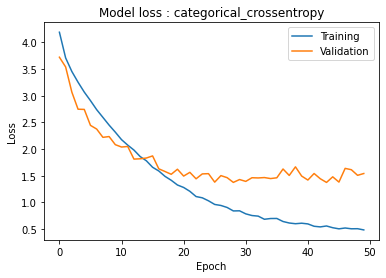

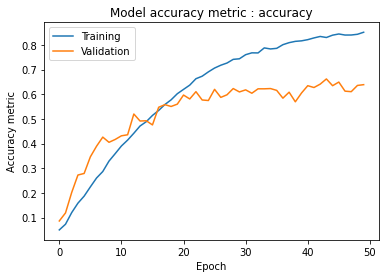

In [ ]:
# model loss
loss='categorical_crossentropy'
metrics=['accuracy']

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history.history[metrics[0]]))
plt.plot(np.array(history.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()



In [ ]:
S_DB_test=np.array(downsample_image(S_DB_test, chosen_input_size))
_, accuracy, top_5_accuracy = vit.evaluate(S_DB_test, person_test_GT, batch_size=BATCH_SIZE)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

30/30 [==============================] - 2s 71ms/step - loss: 1.5910 - accuracy: 0.6116 - top-5-accuracy: 0.8705
Test accuracy: 61.16%
Test top 5 accuracy: 87.05%


In [ ]:
if save_models:
  %cd trained_models/
  vit.save('TRANSFO_Model_clean')
  %cd ..
  # to load back model: keras.models.load_model('mode_folder_name')

/content/drive/.shortcut-targets-by-id/1K5OFKaoitJ_c6tsV6UYFW_Ts0E8dqdld/DLOI_Project/trained_models


INFO:tensorflow:Assets written to: TRANSFO_Model_clean/assets


INFO:tensorflow:Assets written to: TRANSFO_Model_clean/assets


/content/drive/.shortcut-targets-by-id/1K5OFKaoitJ_c6tsV6UYFW_Ts0E8dqdld/DLOI_Project


## ViT using Shifted Patch Tokenization and Locality Self-Attention modified

### Augemented audio files

In [ ]:
# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history_sl = run_experiment(vit_sl)


Epoch 1/50
268/268 [==============================] - 75s 227ms/step - loss: 3.9585 - accuracy: 0.0896 - top-5-accuracy: 0.2813 - val_loss: 2.9981 - val_accuracy: 0.2505 - val_top-5-accuracy: 0.5547
Epoch 2/50
268/268 [==============================] - 59s 220ms/step - loss: 3.2349 - accuracy: 0.1716 - top-5-accuracy: 0.4516 - val_loss: 2.7054 - val_accuracy: 0.3084 - val_top-5-accuracy: 0.5895
Epoch 3/50
268/268 [==============================] - 59s 220ms/step - loss: 2.9290 - accuracy: 0.2339 - top-5-accuracy: 0.5333 - val_loss: 2.4253 - val_accuracy: 0.3568 - val_top-5-accuracy: 0.6821
Epoch 4/50
268/268 [==============================] - 59s 220ms/step - loss: 2.7276 - accuracy: 0.2651 - top-5-accuracy: 0.5945 - val_loss: 2.5634 - val_accuracy: 0.3137 - val_top-5-accuracy: 0.6432
Epoch 5/50
268/268 [==============================] - 59s 220ms/step - loss: 2.5928 - accuracy: 0.3025 - top-5-accuracy: 0.6313 - val_loss: 2.1951 - val_accuracy: 0.4137 - val_top-5-accuracy: 0.7316
Epoch

In [ ]:
vit_sl.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 110, 110, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_2[0][0]']                
                                                                                                  
 shifted_patch_tokenization_3 (  ((None, 144, 64),   35704       ['data_augmentation[1][0]']      
 ShiftedPatchTokenization)       (None, 12, 12, 540                                               
                                ))                                                          

### Results

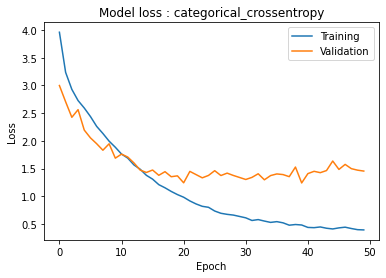

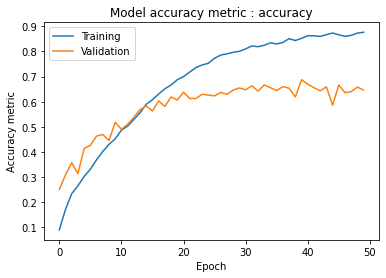

In [ ]:
# model loss
loss='categorical_crossentropy'
metrics=['accuracy']

plt.plot(history_sl.history['loss'])
plt.plot(history_sl.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history_sl.history[metrics[0]]))
plt.plot(np.array(history_sl.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

In [ ]:
test_model_ViT = True
if test_model_ViT:  
  S_DB_test=np.array(downsample_image(S_DB_test, chosen_input_size))
  _, accuracy, top_5_accuracy = vit_sl.evaluate(S_DB_test, person_test_GT, batch_size=BATCH_SIZE)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

30/30 [==============================] - 3s 82ms/step - loss: 1.4845 - accuracy: 0.6484 - top-5-accuracy: 0.8789
Test accuracy: 64.84%
Test top 5 accuracy: 87.89%


In [ ]:
if save_models:
  %cd trained_models/
  vit_sl.save('TRANSFO_Model_sl_clean')
  %cd ..
  # to load back model: keras.models.load_model('MS_Model')

/content/drive/.shortcut-targets-by-id/1K5OFKaoitJ_c6tsV6UYFW_Ts0E8dqdld/DLOI_Project/trained_models


INFO:tensorflow:Assets written to: TRANSFO_Model_sl_clean/assets


INFO:tensorflow:Assets written to: TRANSFO_Model_sl_clean/assets


/content/drive/.shortcut-targets-by-id/1K5OFKaoitJ_c6tsV6UYFW_Ts0E8dqdld/DLOI_Project


### Non-Augemented audio files

In [ ]:
# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_na_sl = create_vit_classifier(vanilla=False)
history_na_sl = run_experiment(vit_na_sl)


Epoch 1/50
90/90 [==============================] - 27s 129ms/step - loss: 4.6546 - accuracy: 0.0435 - top-5-accuracy: 0.1596 - val_loss: 3.7312 - val_accuracy: 0.0811 - val_top-5-accuracy: 0.2905
Epoch 2/50
90/90 [==============================] - 9s 105ms/step - loss: 3.7719 - accuracy: 0.0895 - top-5-accuracy: 0.2789 - val_loss: 3.3043 - val_accuracy: 0.2032 - val_top-5-accuracy: 0.4621
Epoch 3/50
90/90 [==============================] - 9s 95ms/step - loss: 3.5070 - accuracy: 0.1323 - top-5-accuracy: 0.3726 - val_loss: 3.1161 - val_accuracy: 0.2242 - val_top-5-accuracy: 0.5000
Epoch 4/50
90/90 [==============================] - 9s 96ms/step - loss: 3.3772 - accuracy: 0.1505 - top-5-accuracy: 0.4144 - val_loss: 2.9427 - val_accuracy: 0.2368 - val_top-5-accuracy: 0.5611
Epoch 5/50
90/90 [==============================] - 8s 88ms/step - loss: 3.2439 - accuracy: 0.1733 - top-5-accuracy: 0.4530 - val_loss: 2.7334 - val_accuracy: 0.3032 - val_top-5-accuracy: 0.6168
Epoch 6/50
90/90 [====

### Results

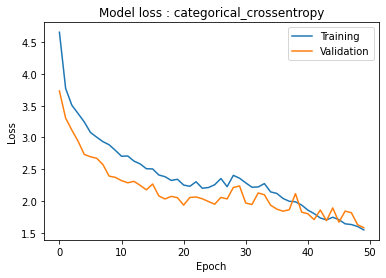

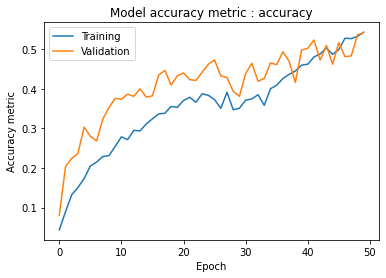

In [ ]:
# model loss
loss='categorical_crossentropy'
metrics=['accuracy']

plt.plot(history_na_sl.history['loss'])
plt.plot(history_na_sl.history['val_loss'])
plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history_na_sl.history[metrics[0]]))
plt.plot(np.array(history_na_sl.history['val_' + metrics[0]]))
plt.title('Model accuracy metric : ' + metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

In [ ]:
test_model_ViT = True
if test_model_ViT:  
  S_DB_test=np.array(downsample_image(S_DB_test, chosen_input_size))
  _, accuracy, top_5_accuracy = vit_na_sl.evaluate(S_DB_test, person_test_GT, batch_size=BATCH_SIZE)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

30/30 [==============================] - 1s 32ms/step - loss: 1.5660 - accuracy: 0.5432 - top-5-accuracy: 0.8589
Test accuracy: 54.32%
Test top 5 accuracy: 85.89%
